In [95]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

from transformer import TransformerConfig
from lm import LM

from data import Dataset

In [83]:
class AutoEncoder(nn.Module):
    def __init__(self, act_size, num_features, l1_coeff):
        super().__init__()

        self.l1_coeff = l1_coeff
        self.num_features = num_features

        self.W_enc = nn.Parameter(torch.nn.init.kaiming_uniform_(torch.empty(act_size, num_features)))
        self.W_dec = nn.Parameter(torch.nn.init.kaiming_uniform_(torch.empty(num_features, act_size)))
        self.b_enc = nn.Parameter(torch.zeros(num_features))
        self.b_dec = nn.Parameter(torch.zeros(act_size))

        self.W_dec.data[:] = self.W_dec / self.W_dec.norm(dim=-1, keepdim=True)
    
    def forward(self, x):
        x_cent = x - self.b_dec
        acts = F.relu(x_cent @ self.W_enc + self.b_enc)
        x_reconstruct = acts @ self.W_dec + self.b_dec
        l2_loss = (x_reconstruct.float() - x.float()).pow(2).sum(-1).mean(0)
        l1_loss = self.l1_coeff * (acts.float().abs().sum())
        loss = l2_loss + l1_loss
        return loss, x_reconstruct, acts, l2_loss, l1_loss
    
    @torch.no_grad()
    def make_decoder_weights_and_grad_unit_norm(self):
        W_dec_normed = self.W_dec / self.W_dec.norm(dim=-1, keepdim=True)
        W_dec_grad_proj = (self.W_dec.grad * W_dec_normed).sum(-1, keepdim=True) * W_dec_normed
        self.W_dec.grad -= W_dec_grad_proj
        # Bugfix(?) for ensuring W_dec retains unit norm, this was not there when I trained my original autoencoders.
        self.W_dec.data = W_dec_normed

In [87]:
dataset = Dataset()

config = TransformerConfig(d_model=64, n_layers=1, n_heads=8, max_len=dataset.max_len, dropout=0.)
model = LM(config, vocab_size=len(dataset.vocabulaire))
model.load_state_dict(torch.load("transformer_d_model64_n_heads8_1_57_1_68.pth", map_location=torch.device('cpu')))

sae = AutoEncoder(act_size=config.d_model, num_features=4*config.d_model, l1_coeff=3e-4) # 3e-4 marche bien
optim = torch.optim.Adam(sae.parameters(), lr=3e-4) # 3e-4 marche bien

In [103]:
for i in range(1000):
    X, Y = dataset.get_batch('train', 16) # (B, L)

    act = model(X, act=True).view(-1, config.d_model) # (B*L, 128)

    loss, x_reconstruct, features, l2_loss, l1_loss = sae(act)
    loss.backward()
    sae.make_decoder_weights_and_grad_unit_norm()
    optim.step()
    optim.zero_grad()
    
    if i%100==0:
        print(f"loss : {loss.item()}")

# features freq
X, Y = dataset.get_batch('val', 512) # (B, L)
act = model(X, act=True).view(-1, config.d_model)
_, _, features, _, _ = sae(act)

print(f"frac of features with freq < 1/100 : {((((features>0).int()).sum(0) / features.shape[0]) < 1e-2).float().mean()}")
print(f"frac of features with freq < 1/1,000 : {((((features>0).int()).sum(0) / features.shape[0]) < 1e-3).float().mean()}")
print(f"frac of features with freq < 1/10,000 : {((((features>0).int()).sum(0) / features.shape[0]) < 1e-4).float().mean()}")

loss : 0.8865005373954773
loss : 0.7893868684768677
loss : 0.802141547203064
loss : 0.8547680377960205
loss : 0.8126266002655029
loss : 0.89870285987854
loss : 0.799763560295105
loss : 0.8171074390411377
loss : 0.8182780742645264
loss : 0.849945068359375
frac of features with freq < 1/100 : 0.30859375
frac of features with freq < 1/1,000 : 0.08984375
frac of features with freq < 1/10,000 : 0.00390625


In [104]:
torch.save(sae.state_dict(), "sae_d_model64_e4.pth")

In [105]:
# feature and act reconstruction viz

X, Y = dataset.get_batch('train', 1) # (B, L)
act = model(X, act=True).view(-1, config.d_model) # (B, L, d_model)
_, act_recon, features, _, _ = sae(act)

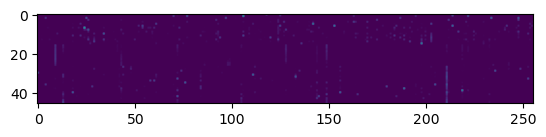

In [106]:
plt.imshow(features.detach())

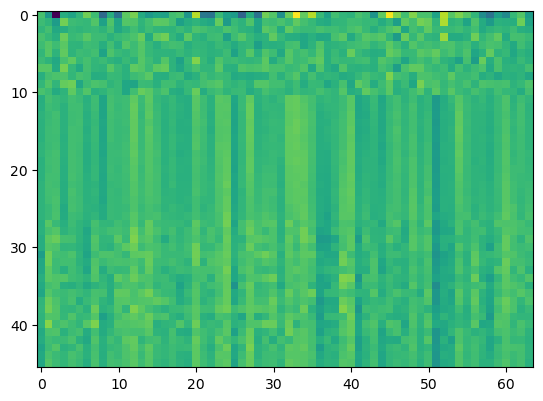

In [98]:
plt.imshow(act.detach())

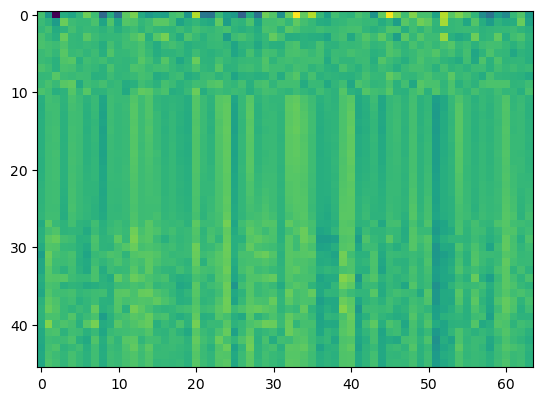

In [99]:
plt.imshow(act_recon.detach())

In [16]:
X, Y = dataset.get_batch('val', 16) # (B, L)
act = model(X, act=True).view(-1, config.d_model)
_, act_recon, features, _, _ = sae(act)

x = model.out_norm(act_recon)
logits = model.lm_head(x)

loss = F.cross_entropy(logits.view(-1, logits.size(-1)), Y.view(-1), ignore_index=dataset.char_to_int['<pad>'])
print(f"reconstruction loss : {loss.item():.2f}")

reconstruction loss : 1.71


In [17]:
# model loss : 1.75

### neurones interprétables ?

In [12]:
top_k = 20
batch_size = 64

In [13]:
def update_top_k(top_values, top_indices, new_values, new_indices, k=20):
    combined_values = torch.cat([top_values, new_values])
    combined_indices = torch.cat([top_indices, new_indices])
    
    new_top_values, topk_indices = torch.topk(combined_values, k)
    new_top_indices = combined_indices[topk_indices]
    
    return new_top_values, new_top_indices

In [14]:
top_values = torch.full((config.d_model, top_k), -float('inf'))
top_indices = torch.full((config.d_model, top_k), -1, dtype=torch.long)

for i in range(0, dataset.X_train.shape[0], batch_size):
    X = dataset.X_train[i:i+batch_size]
    act = model(X, act=True) # (B, L, 128)
    max_act = act.max(dim=1).values # (B, 128)

    for dim in range(config.d_model):
        dim_values = max_act[:, dim]
        dim_indices = i + torch.arange(batch_size)

        top_values[dim], top_indices[dim] = update_top_k(top_values[dim], top_indices[dim], dim_values, dim_indices)

In [26]:
neurone = 56 # 21 = morville
for i in top_indices[neurone]:

    ville = "".join([dataset.int_to_char[k] for k in [p.item() for p in dataset.X_train[i.item()] if p.item() != 0] if k != 1 and k != 2])
    act = model(dataset.X_train[i.item()].unsqueeze(0), act=True) # (B, L, 128)

    print_colore(ville, act[0, :, neurone].tolist()[:len(ville)])

# 58 = saint

### features interprétables ?

In [18]:
top_k = 20
batch_size = 64

In [19]:
def update_top_k(top_values, top_indices, new_values, new_indices, k=20):
    combined_values = torch.cat([top_values, new_values])
    combined_indices = torch.cat([top_indices, new_indices])
    
    new_top_values, topk_indices = torch.topk(combined_values, k)
    new_top_indices = combined_indices[topk_indices]
    
    return new_top_values, new_top_indices

In [20]:
top_values = torch.full((sae.num_features, top_k), -float('inf'))
top_indices = torch.full((sae.num_features, top_k), -1, dtype=torch.long)

for i in range(0, X_train.shape[0], batch_size):
    X = X_train[i:i+batch_size]
    act = model(X, act=True) # (B, L, 128)
    _, _, features, _, _ = sae(act)
    max_features = features.max(dim=1).values # (B, 128)

    for dim in range(sae.num_features):
        dim_values = max_features[:, dim]
        dim_indices = i + torch.arange(batch_size)

        top_values[dim], top_indices[dim] = update_top_k(top_values[dim], top_indices[dim], dim_values, dim_indices)

In [41]:
feature = 200
for i in top_indices[feature]:
    ville = "".join([int_to_char[k] for k in [p.item() for p in X_train[i.item()] if p.item() != 0] if k != 1 and k != 2])
    act = model(X_train[i.item()].unsqueeze(0), act=True) # (B, L, 128)
    _, _, features, _, _ = sae(act)

    print_colore(ville, features[0, :, feature].tolist()[:len(ville)])

# 7 = saint mais pas au début
# 8 = saint
# 9 = présence de "ch"